Build a GA that constructs exam or class timetables under realistic constraints.
For the project, choose one small or medium-sized instance (from Toronto or ITC 2007) and
implement at least:
● all hard constraints (no student in two exams at the same time),
● one or two soft criteria in your fitness function.

By 10 December you should submit a complete mini-project:
A working GA implementation for your chosen problem and dataset.

- At least a few experiments:  
   -  different parameter settings and/or different fitness/operators,  
   -  several runs per configuration, with basic metrics (best/average quality, etc.).  

- clean repository:  
   - readable code  
   - clear instructions in README (how to run, what to expect),  
   - a short summary of results and main conclusions.  

I'm going to use Toronto dataset

In [2]:
import random
from typing import List, Tuple

# For reproducibility
random.seed(42)

test_dataset = "datasets-older/uta-s-92"
exam_dataset_path = test_dataset + ".crs"
students_dataset_path = test_dataset + ".stu"

Representation format: Array of N elements, where N - number of exams.  
So genom always contains all and indeed valid.

In [3]:
my_candidate = [0, 1, 2, 0, 3, 2]

In [4]:
def read_exams(path: str) -> List[int]:
    f = open(path, "r")
    frl = f.readlines()
    exams = [int(el.split()[0]) for el in frl]
    return exams

def read_students(path: str) -> List[List[int]]:
    f = open(path, "r")
    frl = f.readlines()
    students = list(map(lambda x: list(map(int, x.split())), frl))
    return students

exams = read_exams(exam_dataset_path)
students = read_students(students_dataset_path)

number_of_exams = len(exams)
number_of_students = len(students)

c = [[0 for _ in range(number_of_exams + 1)] for _ in range(number_of_exams + 1)]

def intersect_exams(students: List[List[int]])-> List[List[int]]:
    for student in students:
        for a in student:
            for b in student:
                if a != b:
                    c[a][b] += 1

intersect_exams(students)

In [47]:
from math import comb

def soft_fitness(individual):
    fit = 0

    for i in range(number_of_exams):
        slot_i = individual[i]

        for j in range(i + 1, number_of_exams):
            slot_j = individual[j]

            conflict = c[i][j]
            if conflict == 0:
                continue

            if abs(slot_i - slot_j) >= 5:
                continue

            dt = abs(slot_i - slot_j)

            w = 2 ** max(0, 4 - dt)
            fit -= w * conflict

    return fit


In [6]:
my_candidate = list(random.randint(0, 5) for _ in range(number_of_exams))
fit_value = soft_fitness(my_candidate)
print(f"Fitness of candidate {my_candidate} is {fit_value}")

Fitness of candidate [5, 0, 0, 5, 2, 1, 1, 1, 5, 0, 5, 5, 4, 0, 4, 3, 0, 0, 0, 1, 1, 4, 4, 0, 4, 1, 5, 5, 5, 4, 3, 1, 3, 4, 2, 0, 1, 5, 3, 2, 2, 1, 1, 2, 0, 0, 3, 0, 2, 2, 4, 2, 0, 5, 3, 4, 0, 3, 0, 4, 2, 5, 4, 2, 4, 1, 5, 0, 0, 5, 1, 2, 0, 1, 0, 3, 2, 3, 5, 2, 1, 2, 2, 1, 5, 2, 5, 5, 5, 0, 4, 5, 1, 4, 5, 1, 1, 3, 3, 2, 5, 5, 4, 1, 5, 2, 0, 1, 0, 2, 3, 2, 0, 1, 4, 5, 2, 1, 5, 3, 3, 5, 3, 1, 2, 1, 1, 5, 4, 4, 2, 5, 4, 3, 4, 3, 2, 1, 1, 4, 3, 0, 0, 0, 1, 5, 1, 5, 3, 4, 0, 3, 3, 4, 3, 4, 2, 4, 0, 5, 5, 0, 5, 4, 2, 5, 2, 0, 2, 3, 1, 3, 0, 5, 5, 2, 4, 1, 4, 0, 5, 2, 5, 4, 4, 1, 1, 2, 1, 4, 4, 0, 4, 2, 3, 0, 0, 2, 2, 1, 0, 1, 4, 0, 0, 5, 3, 0, 4, 1, 1, 5, 3, 4, 1, 2, 4, 4, 3, 1, 4, 5, 5, 1, 5, 2, 3, 5, 5, 2, 3, 4, 3, 0, 1, 1, 0, 2, 0, 4, 4, 1, 4, 1, 0, 0, 5, 5, 0, 1, 0, 0, 2, 0, 4, 1, 2, 5, 3, 1, 4, 1, 5, 4, 4, 3, 1, 3, 3, 1, 0, 0, 5, 3, 2, 3, 3, 3, 5, 0, 5, 5, 5, 0, 0, 3, 5, 2, 0, 1, 1, 1, 4, 3, 1, 3, 1, 2, 3, 1, 0, 3, 4, 0, 0, 5, 4, 0, 0, 1, 1, 3, 3, 3, 1, 3, 0, 1, 3, 0, 3, 2, 3, 2, 3, 5, 

### Tournament

In [7]:
def create_initial_population(pop_size: int,
                              exam_count: int,
                              max_time_slot: int = 50) -> List[List[int]]:
    """Create an initial population of random individuals."""
    population = []
    for _ in range(pop_size):
        individual = [random.randint(0, max_time_slot - 1)
                      for _ in range(exam_count)]
        population.append(individual)
    return population

def tournament_selection(population: List[List[int]],
                         fitnesses: List[int],
                         k: int = 3) -> List[int]:
    """Select one parent using tournament selection."""
    idxs = random.sample(list(range(len(population))), k)
    fitnesses = [(fitnesses[i], i) for i in idxs]
    return population[max(fitnesses)[1]]
population = create_initial_population(10, number_of_exams)

### Crossover

In [8]:
from typing import Tuple, List
import random

def one_point_crossover(parent1: List[int],
                        parent2: List[int],
                        crossover_prob: float = 0.8) -> Tuple[List[int], List[int]]:
    """
    Perform one-point crossover with given probability.
    """
    n = number_of_exams

    r = random.random()
    if r > crossover_prob:
      return (parent1, parent2)
    c = random.randint(1, n-2)
    child1 = parent1[:c] + parent2[c:]
    child2 = parent2[:c] + parent1[c:]

    return (child1, child2)

### Mutation

In [9]:
def mutate(individual: List[int],
           mutation_prob: float = 0.1,
           max_time_slots: int = 50) -> None:
    """
    Mutate the individual *in place*.
    """
    n = number_of_exams
    for i in range(n):
      if random.random() < mutation_prob:
        individual[i] = random.randint(0, max_time_slots - 1)

### Main loop

In [49]:
def genetic_algorithm(pop_size: int = 50,
                      max_generations: int = 200,
                      crossover_prob: float = 0.8,
                      mutation_prob: float = 0.1,
                      tournament_k: int = 30,
                      max_time_slots: int = 50,
                      verbose: bool = True,
                      n_jobs: int = 1,
                      fitness_function = soft_fitness):
    """
    Run the genetic algorithm and return:
    - best individual found,
    - its fitness,
    - generation index when the optimum was first reached (or None if not reached).
    """
    # 1) Initialise population
    population = create_initial_population(pop_size, number_of_exams, max_time_slots)

    best_individual = None
    best_fitness = float("-inf")
    success_generation = None  # will stay None if we never hit the optimum

    for gen in range(max_generations):
        fitnesses = [soft_fitness(ind) for ind in population]

        best_idx = max(range(len(population)), key=lambda i: fitnesses[i])
        if fitnesses[best_idx] > best_fitness:
            best_fitness = fitnesses[best_idx]
            best_individual = population[best_idx][:]

        if verbose and gen % 10 == 0:
            print(f"Generation {gen:3d}: best fitness = {best_fitness}")

        max_possible = 0
        if best_fitness == max_possible:
            success_generation = gen
            if verbose:
                print(f"Solution found at generation {gen}!")
            break

        # 5) Create new population
        new_population: List[List[int]] = []

        while len(new_population) < pop_size:
            parent1 = tournament_selection(population, fitnesses, tournament_k)
            parent2 = tournament_selection(population, fitnesses, tournament_k)
            children = one_point_crossover(parent1, parent2, crossover_prob)
            mutate(children[0], mutation_prob, max_time_slots)
            mutate(children[1], mutation_prob, max_time_slots)
            new_population.append(children[0])
            new_population.append(children[1])

        population = new_population[:pop_size]

    return best_individual, best_fitness, success_generation

best, best_f, gen_succ = genetic_algorithm()
print("Best fitness:", best_f)
print("Success generation:", gen_succ)


Generation   0: best fitness = -62249
Generation  10: best fitness = -51669
Generation  10: best fitness = -51669
Generation  20: best fitness = -51290
Generation  20: best fitness = -51290


KeyboardInterrupt: 

### Experiments

I have been added parallel coputation of fitness, but with large number of exams process is still pretty slow

Also I've modified the fitness function, to achieve complete achievement of "hard" recuirements - and noticed, that at the most (or even all) datasets that is impossible

In [50]:
from multiprocessing import Pool

def hard_fitness(individual):
    fit = 0
    for i in range(number_of_exams):
        slot_i = individual[i]
        for j in range(i + 1, number_of_exams):
            slot_j = individual[j]
            id_i = exams[i]
            id_j = exams[j]
            
            conflict = c[id_i][id_j]
            
            if conflict > 0 and slot_i == slot_j:
                fit -= conflict
    return fit

best, best_f, gen_succ = genetic_algorithm(
    pop_size=100,
    max_generations=2000,
    crossover_prob=0.8,
    mutation_prob= 0.001,
    tournament_k=20,
    max_time_slots=35,
    n_jobs=8,
    fitness_function=hard_fitness
)
print("Best fitness:", best_f)
print("Success generation:", gen_succ)
print(best)

Generation   0: best fitness = -82355


KeyboardInterrupt: 

In [43]:
print("Hard fitness of the best individual:", hard_fitness(best))

Hard fitness of the best individual: -59


In [ ]:
# Experiment 1:
(
    pop_size=50,
    max_generations=200,
    crossover_prob=0.8,
    mutation_prob= 0.01,
    tournament_k=20,
    max_time_slots=50
)
# result: -362

# Experiment 2:
(
    pop_size=50,
    max_generations=200,
    crossover_prob=0.7,
    mutation_prob= 0.002,
    tournament_k=30,
    max_time_slots=50
)
# result: -261

# Exp 3
(
    pop_size=60,
    max_generations=400,
    crossover_prob=0.8,
    mutation_prob= 0.001,
    tournament_k=40,
    max_time_slots=50
)

# result: Best fitness: -100

# Exp 4

(
    pop_size=100,
    max_generations=2000,
    crossover_prob=0.8,
    mutation_prob= 0.001,
    tournament_k=20,
    max_time_slots=35,
    n_jobs=8,
)
# result - on UTA92 dataset: -89


SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (1384525115.py, line 3)

### Solution reader

In [44]:
def read_solution(path: str) -> List[int]:
    f = open(path, "r")
    frl = f.readlines()
    solution = [int(el.split()[1]) for el in frl]
    return solution

path_to_solution = "uta92.sol"

print("Best fitness:", best_f)
solution = read_solution(path_to_solution)
print(len(solution), number_of_exams)

print("Solution_fitness:", hard_fitness(read_solution(path_to_solution)))

Best fitness: -59
622 622
Solution_fitness: -2756


"Etalon" solution result: 2355 students have intersections (not even exams in one day - exams in one time)
Genetic solution after 2000 steps of generation: 2446, what is pretty close

### Soft limitations

lets draw some initial solutions, then add some additional limitations, and look how result changes - will changes of out demands make visible changes in result?

1. Hard limitations:

[1. 3. 2. 2. 2. 3. 2. 0. 2. 2. 1. 2. 3. 4. 2. 2. 1. 0. 1. 2. 0. 2. 2. 1.
 2. 1. 1. 3. 1. 0. 1. 2. 0. 3. 3.]


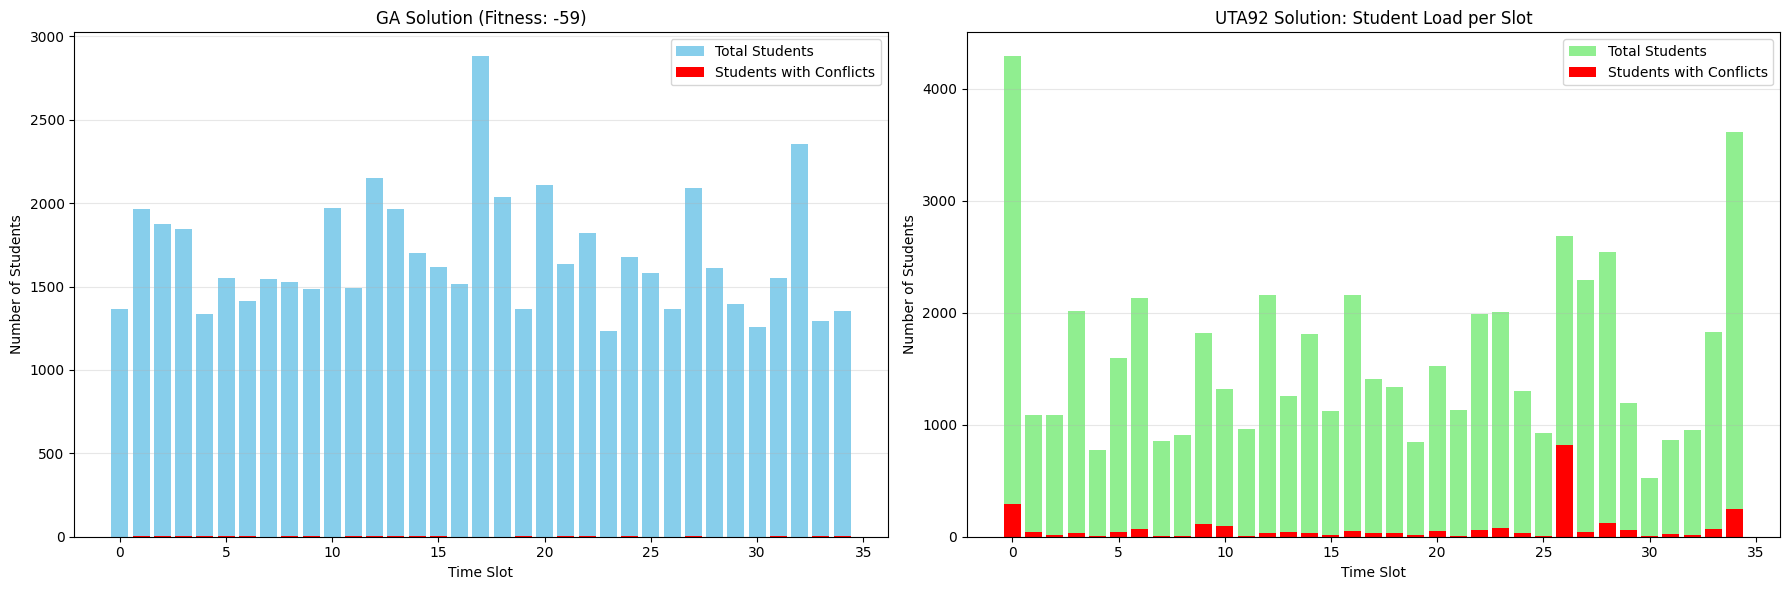

In [45]:
import matplotlib.pyplot as plt
import numpy as np

def get_student_stats(schedule, students_list, exams_list):
    """
    Calculates the number of students and conflicts per time slot.
    schedule: list where index i is the time slot for exam ID exams_list[i]
    students_list: list of lists, where each inner list contains exam IDs for a student
    exams_list: list of exam IDs corresponding to the schedule indices
    """
    if not schedule:
        return [], []
    
    max_slot = max(schedule)
    total_students = np.zeros(max_slot + 1)
    conflict_students = np.zeros(max_slot + 1)
    
    # Create a map from exam_id to index in the schedule
    # This ensures we look up the correct slot even if exam IDs are not 1..N or not sorted
    exam_id_to_idx = {exam_id: idx for idx, exam_id in enumerate(exams_list)}
    
    for student in students_list:
        student_slots = []
        for exam_id in student:
            if exam_id in exam_id_to_idx:
                idx = exam_id_to_idx[exam_id]
                student_slots.append(schedule[idx])
        
        unique_slots = set(student_slots)
        for s in unique_slots:
            total_students[s] += 1
            if student_slots.count(s) > 1:
                conflict_students[s] += 1
                
    return total_students, conflict_students

# 1. Prepare Data
ga_schedule = best

# 2. Calculate Stats
# Pass 'exams' list to ensure correct mapping!
ga_total, ga_conflict = get_student_stats(ga_schedule, students, exams)
sol_total, sol_conflict = get_student_stats(solution, students, exams)

print(ga_conflict)

# 3. Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot GA Solution
slots_ga = range(len(ga_total))
axes[0].bar(slots_ga, ga_total, label='Total Students', color='skyblue')
axes[0].bar(slots_ga, ga_conflict, label='Students with Conflicts', color='red')
axes[0].set_title(f'GA Solution (Fitness: {best_f})')
axes[0].set_xlabel('Time Slot')
axes[0].set_ylabel('Number of Students')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot Etalon Solution
slots_sol = range(len(sol_total))
axes[1].bar(slots_sol, sol_total, label='Total Students', color='lightgreen')
axes[1].bar(slots_sol, sol_conflict, label='Students with Conflicts', color='red')
axes[1].set_title('UTA92 Solution: Student Load per Slot')
axes[1].set_xlabel('Time Slot')
axes[1].set_ylabel('Number of Students')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

2: with limitations on hours

In [ ]:
best, best_f, gen_succ = genetic_algorithm(
    pop_size=50,
    max_generations=100,
    crossover_prob=0.8,
    mutation_prob= 0.001,
    tournament_k=20,
    max_time_slots=35,
    n_jobs=8,
    fitness_function=soft_fitness
)
print("Best fitness:", best_f)
print("Success generation:", gen_succ)
print(best)

print(soft_fitness(solution))

Generation   0: best fitness = -86212
Generation  10: best fitness = -78247
Generation  10: best fitness = -78247
Generation  20: best fitness = -75567
Generation  20: best fitness = -75567
Generation  30: best fitness = -72354
Generation  30: best fitness = -72354
Generation  40: best fitness = -70494
Generation  40: best fitness = -70494
Generation  50: best fitness = -68072
Generation  50: best fitness = -68072
Generation  60: best fitness = -66618
Generation  60: best fitness = -66618
Generation  70: best fitness = -65201
Generation  70: best fitness = -65201
Generation  80: best fitness = -63639
Generation  80: best fitness = -63639
Generation  90: best fitness = -62325
Generation  90: best fitness = -62325
Best fitness: -61367
Success generation: None
[32, 16, 13, 33, 24, 31, 21, 0, 31, 17, 13, 32, 1, 20, 8, 33, 25, 15, 13, 4, 17, 15, 2, 16, 31, 2, 11, 13, 0, 11, 9, 0, 19, 10, 26, 15, 25, 29, 2, 33, 1, 13, 20, 28, 5, 16, 29, 20, 18, 25, 17, 27, 3, 29, 0, 2, 21, 2, 15, 14, 18, 8, 

In [57]:
print(soft_fitness(solution))

-91351


[ 76.  30.  52.  25.  43.  14.   6.  15.  15.  65.  64.  32.  26. 142.
  28. 222.  27.  78.  64.  30.  29.  22.  22.  38.  81.  29.  10.  73.
  35.  15.  37.  95.  48.  40.  44.]


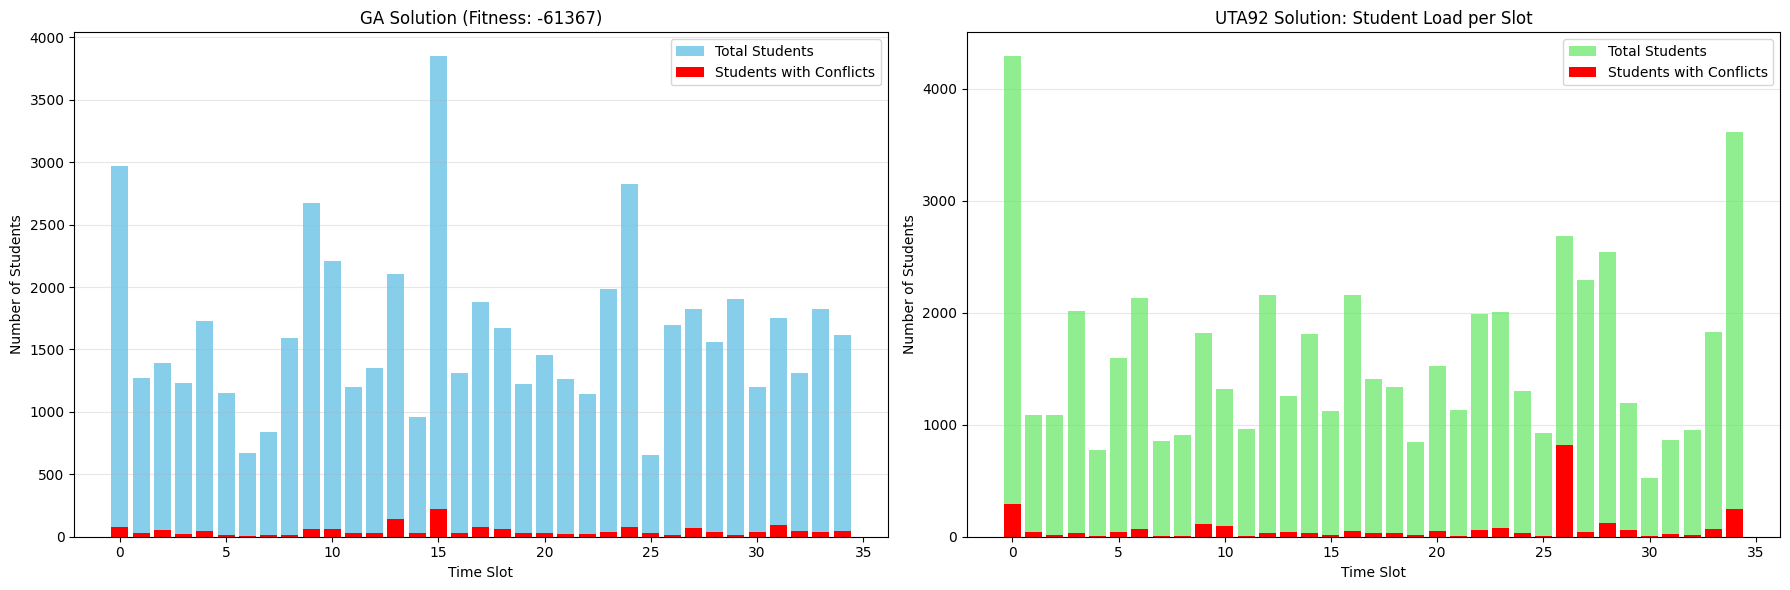

In [ ]:
ga_schedule = best

# 2. Calculate Stats
# Pass 'exams' list to ensure correct mapping!
ga_total, ga_conflict = get_student_stats(ga_schedule, students, exams)
sol_total, sol_conflict = get_student_stats(solution, students, exams)

# 3. Plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot GA Solution
slots_ga = range(len(ga_total))
axes[0].bar(slots_ga, ga_total, label='Total Students', color='skyblue')
axes[0].bar(slots_ga, ga_conflict, label='Students with Conflicts', color='red')
axes[0].set_title(f'GA Solution (Fitness: {best_f})')
axes[0].set_xlabel('Time Slot')
axes[0].set_ylabel('Number of Students')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot Etalon Solution

slots_sol = range(len(sol_total))
axes[1].bar(slots_sol, sol_total, label='Total Students', color='lightgreen')
axes[1].bar(slots_sol, sol_conflict, label='Students with Conflicts', color='red')
axes[1].set_title('UTA92 Solution: Student Load per Slot')
axes[1].set_xlabel('Time Slot')
axes[1].set_ylabel('Number of Students')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

We clearly can see that graph became more spiky, with larger variety, also 0 value doubled (because it has less neibhours). However, 34 didn't stayed the same (strange result)